# GPX file reading and datascience

In [14]:
import gpxpy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns  
from math import radians, sin, cos, sqrt, atan2, tan
%matplotlib inline 

### Reading a gpx file and inserting its data in a dataframe

In [16]:
# Load the GPX file

filename = 'gpx_file5.gpx'
gpx_file = open(filename, 'r')
gpx = gpxpy.parse(gpx_file)

# Create empty lists to store data
latitude = []
longitude = []
elevation = []
time = []
heartrate = []

# Iterate through the GPX data points
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            latitude.append(point.latitude)
            longitude.append(point.longitude)
            elevation.append(point.elevation if point.elevation is not None else 0)  # Handle None values
            time.append(point.time)
            if point.extensions:
                for ext in point.extensions:
                    for extchild in list(ext):
                        heartrate.append(int(extchild.text))
            else:
                heartrate.append(0)
                

# Create a DataFrame
data = {
    'Time': time,
    'Latitude': latitude,
    'Longitude': longitude,
    'Elevation': elevation,
    'Heartrate':heartrate
    
}
df = pd.DataFrame(data)

# Close the GPX file
gpx_file.close()

df


,Time,Latitude,Longitude,Elevation,Heartrate
0,2023-11-29 08:26:05+00:00,41.265016,1.950697,5.13,0
1,2023-11-29 08:26:16+00:00,41.265069,1.950438,5.36,0
2,2023-11-29 08:26:20+00:00,41.265035,1.950200,5.70,115
3,2023-11-29 08:26:24+00:00,41.265016,1.949901,6.16,117
4,2023-11-29 08:26:27+00:00,41.264988,1.949634,6.72,120
...,...,...,...,...,...
666,2023-11-29 09:43:06+00:00,41.266986,1.943609,12.28,153
667,2023-11-29 09:43:09+00:00,41.267064,1.943924,9.89,150
668,2023-11-29 09:43:12+00:00,41.267151,1.944225,7.66,147
669,2023-11-29 09:43:15+00:00,41.267217,1.944517,7.60,147


### Calculating some common parameters

In [17]:
# Cumulative Time

df['Cumulative_Time'] = (df['Time'] - df['Time'].min()).dt.total_seconds() / 60.0


# Cumulative_Distance in km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c  # Distance in kilometers
    return distance

df['Cumulative_Distance'] = np.cumsum(haversine(df['Latitude'].shift(), df['Longitude'].shift(), df['Latitude'], df['Longitude']).fillna(0))

# Velocity in km/h

df['Velocity'] = (df['Cumulative_Distance'].diff() / df['Cumulative_Time'].diff()) * 60  # Convert from minutes to hours

# Slope in degrees

skip_values = 2  # Set the number of values to skip for smoothing

df['Slope'] = np.degrees(np.arctan2(df['Elevation'].diff(periods=skip_values), df['Cumulative_Distance'].diff(periods=skip_values)*1000))


# Smoothed elevation

df['Smoothed_Elevation'] = df['Elevation'].rolling(window=10, min_periods=1).mean()


# Cumulative elevation

positive_changes = df['Smoothed_Elevation'].diff().clip(lower=0)
df['Cumulative_Elevation'] = positive_changes.cumsum()

# Smoothed Slope
df['Smooth_Slope'] = np.degrees(np.arctan2(df['Smoothed_Elevation'].diff(), df['Cumulative_Distance'].diff()*1000))


# Removing velocity outliers

# Calculate the average of adjacent values for each row
df['average_adjacent'] = df['Velocity'].rolling(window=3, center=False).mean()

# Identify the rows where the velocity is 2 or 3 times larger than the average of adjacent values
outlier_condition = (df['Velocity'] > (df['average_adjacent'] + 20))

# Create a new column 'corrected_velocity' with the corrected values
df['Corrected_Velocity'] = np.where(outlier_condition, df['average_adjacent'], df['Velocity'])

# Substitute values higher than 80 km/h
df['Corrected_Velocity'] = df['Corrected_Velocity'].apply(lambda x: df['Corrected_Velocity'].mean() if x>80 else x )


# Drop the 'average_adjacent' column
df.drop(columns=['average_adjacent'], inplace=True)

# Additional smoothing
df['Corrected_Velocity']=df['Corrected_Velocity'].rolling(window=3, min_periods=1).mean()


df

,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
0,2023-11-29 08:26:05+00:00,41.265016,1.950697,5.13,0,0.000000,0.000000,NaN,NaN,5.130000,NaN,NaN,NaN
1,2023-11-29 08:26:16+00:00,41.265069,1.950438,5.36,0,0.183333,0.022367,7.319980,NaN,5.245000,0.115000,0.294589,7.319980
2,2023-11-29 08:26:20+00:00,41.265035,1.950200,5.70,115,0.250000,0.042691,18.292129,0.764951,5.396667,0.266667,0.427546,12.806054
3,2023-11-29 08:26:24+00:00,41.265016,1.949901,6.16,117,0.316667,0.067768,22.568686,1.009493,5.587500,0.457500,0.436018,16.060265
4,2023-11-29 08:26:27+00:00,41.264988,1.949634,6.72,120,0.366667,0.090282,27.017196,1.227820,5.814000,0.684000,0.576391,22.626003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,2023-11-29 09:43:06+00:00,41.266986,1.943609,12.28,153,77.016667,15.619345,35.814230,0.555431,7.646000,569.330000,1.502832,37.727041
667,2023-11-29 09:43:09+00:00,41.267064,1.943924,9.89,150,77.066667,15.647096,33.301175,-3.239541,8.178000,569.862000,1.098254,36.695960
668,2023-11-29 09:43:12+00:00,41.267151,1.944225,7.66,147,77.116667,15.673999,32.283063,-4.831869,8.493000,570.177000,0.670841,33.799489
669,2023-11-29 09:43:15+00:00,41.267217,1.944517,7.60,147,77.166667,15.699514,30.617984,-2.501528,8.801000,570.485000,0.691603,32.067407


In [18]:
# Statistics

timeMin = round(df['Cumulative_Time'].max(), 1)
timeH = round(timeMin / 60, 1)
distRound = round(df['Cumulative_Distance'].max(), 1)
max_speed = round(df['Corrected_Velocity'].max(), 1)
avg_speed = round(distRound / timeH, 1)
max_slope = round(df['Slope'].max(), 1)
max_hr = df['Heartrate'].max()
mean_hr = round(df['Heartrate'].mean())
max_height =  round(df['Elevation'].max())
min_height =  round(df['Elevation'].min())
cum_elevation =  round(df['Cumulative_Elevation'].max())

# Create a new DataFrame with the calculated values
stat_df = pd.DataFrame({
    'Tiempo en movimiento': [timeMin],
    'Tiempo en movimiento': [timeH],
    'Distancia recorrida': [distRound],
    'Velocidad Máxima': [max_speed],
    'Velocidad media': [avg_speed],
    'Max slope (º)': [max_slope],
    'Max HR (bpm)': [max_hr],
    'Mean HR (bpm)': [mean_hr],
    'Altura Máxima': [max_height],
    'Altura Mínima': [min_height],
    'Ganancia Altitud': [cum_elevation]
})

stat_df=stat_df.transpose()
stat_df.reset_index(inplace=True)
stat_df.columns = ['Parámetro', 'Valor']
stat_df

,Parámetro,Valor
0,Tiempo en movimiento,1.3
1,Distancia recorrida,15.7
2,Velocidad Máxima,68.9
3,Velocidad media,12.1
4,Max slope (º),22.1
5,Max HR (bpm),168.0
6,Mean HR (bpm),140.0
7,Altura Máxima,562.0
8,Altura Mínima,2.0
9,Ganancia Altitud,571.0


### Reading values stored as custom code in GPX files generated by Orux Maps

In [19]:
from bs4 import BeautifulSoup

with open(filename, 'r') as file:
    gpx_file_content = file.read()

# Create a BeautifulSoup object
soup = BeautifulSoup(gpx_file_content, 'html.parser')

lst = []
# Find the <desc> tag
desc_tag = soup.find('desc')

if desc_tag:
    # Extract CDATA content within <desc>
    cdata_content = desc_tag.string
    
    if cdata_content:
        # Parse the CDATA content with BeautifulSoup
        cdata_soup = BeautifulSoup(cdata_content, 'html.parser')
        
        # Find all <br/> tags
        br_tags = cdata_soup.find_all('br')
        
        # Extract text between <br/> tags
        for br_tag in br_tags:
            # Get the next_sibling, which should be the text between <br/> tags
            text_between_br = br_tag.next_sibling
            if text_between_br and isinstance(text_between_br, str):
                extracted_text = text_between_br.strip()
                lst.append(extracted_text)
    else:
        print("No CDATA content found within <desc>.")
else:
    print("No <desc> tag found in the content.")


stat_df_Orux=pd.DataFrame(lst)

stat_df_Orux['Parámetro'] = stat_df_Orux[0].apply(lambda x: x.split(':',maxsplit=1)[0]).apply(lambda x: x.replace('Ã¡','á')).apply(lambda x: x.replace('Ã','í')).apply(lambda x: x.replace('Ã©','é'))
stat_df_Orux['Valor'] = stat_df_Orux[0].apply(lambda x: x.split(':',maxsplit=1)[1]).apply(lambda x: x.split()[0]).apply(lambda x: x.replace(',','.')).apply(lambda x: x[:-2] if x.endswith('km') else x)
#stat_df_Orux['ValueRaw'] = stat_df_Orux['ValueRaw']
stat_df_Orux.drop(0, axis=1, inplace=True)

stat_df_Orux

d:\Programas\Anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,Parámetro,Valor
0,Hora Inicio,9:26
1,Hora Fin,10:43
2,Distancia recorrida,15.7
3,Tiempo en movimiento,01:04
4,Velocidad media,12.22
5,Vel. en Mov.,14.69
6,Velocidad Máxima,65.5
7,Altura Mínima,2
8,Altura Máxima,561
9,Velocidad Ascenso,666.2


### Comparing the values calculated by Orux Maps and stored in the gpx file with the ones calculated by the present code

In [20]:
stat_df_new=pd.merge(stat_df,stat_df_Orux,on='Parámetro', how='outer')
stat_df_new.columns = ['Parámetro','Mis valores', 'Valores Orux']
stat_df_new

,Parámetro,Mis valores,Valores Orux
0,Tiempo en movimiento,1.3,01:04
1,Distancia recorrida,15.7,15.7
2,Velocidad Máxima,68.9,65.5
3,Velocidad media,12.1,12.22
4,Max slope (º),22.1,NaN
5,Max HR (bpm),168.0,NaN
6,Mean HR (bpm),140.0,NaN
7,Altura Máxima,562.0,561
8,Altura Mínima,2.0,2
9,Ganancia Altitud,571.0,614


### Generating interactive plots 

In [78]:
import plotly.express as px
fig = px.line(df, x="Cumulative_Time", y="Corrected_Velocity",
                title="(Interactive plot)",labels={"Cumulative_Time": 'Time (min)', "Corrected_Velocity": 'Velocity (km/h)'}, markers=True )
fig.update_traces(marker=dict(size=2), line=dict(dash='solid', width=1))
fig.show()


In [64]:
# Elevation and cumulative elevation

import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px

# Create subplot with shared x-axis
fig = sp.make_subplots(specs=[[{"secondary_y": True}]])

# Plot Elevation against Cumulative Distance on the first y-axis
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Smoothed_Elevation'],
                         mode='lines', name='Elevation', line=dict(color='blue', width=2)),
              secondary_y=False)

# Add a trace for Cumulative Elevation on the second y-axis
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Cumulative_Elevation'],
                         mode='lines', name='Cumulative Elevation', line=dict(color='red', width=2)),
              secondary_y=True)

# Set x-axis title
fig.update_layout(xaxis=dict(title='Time (min)'))

# Set y-axes titles
fig.update_layout(yaxis=dict(title='Elevation (m)', color='blue'), yaxis2=dict(title='Cumulative Elevation', color='red'))

# Show the plot
fig.show()


In [66]:
# Elevation and heartrate

# Create subplot with shared x-axis
fig = sp.make_subplots(specs=[[{"secondary_y": True}]])

# Plot Elevation against Cumulative Distance on the first y-axis
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Smoothed_Elevation'],
                         mode='lines', name='Elevation', line=dict(color='blue', width=2)),
              secondary_y=False)

# Create a second y-axis for Heartrate
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Heartrate'],
                         mode='lines', name='Heartrate', line=dict(color='red', width=2)),
              secondary_y=True)

# Set x-axis title
fig.update_layout(xaxis=dict(title='Time (min)'))

# Set y-axes titles
fig.update_layout(yaxis=dict(title='Elevation (m)', color='blue'), yaxis2=dict(title='Heartrate', color='red'))

# Show the plot
fig.show()


In [68]:
# Velocity and heartrate

# Create subplot with shared x-axis
fig = sp.make_subplots(specs=[[{"secondary_y": True}]])

# Plot Velocity against Cumulative Time on the first y-axis
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Velocity'],
                         mode='lines', name='Velocity', line=dict(color='blue', width=2)),
              secondary_y=False)

# Create a second y-axis for Heartrate
fig.add_trace(go.Scatter(x=df['Cumulative_Time'], y=df['Heartrate'],
                         mode='lines', name='Heartrate', line=dict(color='red', width=2)),
              secondary_y=True)

# Set x-axis title
fig.update_layout(xaxis=dict(title='Time (min)'))

# Set y-axes titles
fig.update_layout(yaxis=dict(title='Velocity', color='blue'), yaxis2=dict(title='Heartrate', color='red'))

# Show the plot
fig.show()

### Interactive plot of the track over an OpenTopo map layer

In [69]:
import folium

# Create a Folium map centered around the mean coordinates
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=15)

# Add the OpenTopoMap layer
opentopomap_url = 'https://a.tile.opentopomap.org/{z}/{x}/{y}.png'
folium.TileLayer(opentopomap_url, attr='OpenTopoMap').add_to(my_map)

# Create a PolyLine connecting the data points
points = list(zip(df['Latitude'], df['Longitude']))
folium.PolyLine(points, color='blue', weight=2.5, opacity=1).add_to(my_map)

# Plot data values using CircleMarkers (hidden markers)
for index, row in df.iterrows():
    popup_content = (
        f"Speed (km/h): {round(row['Corrected_Velocity'], 1)} <br> "
        f"HR (bpm): {row['Heartrate']} <br> "
        f"Time (min): {round(row['Cumulative_Time'], 1)} <br> "
        f"Distance (km): {round(row['Cumulative_Distance'], 2)} <br> "
        f"Slope: {round(row['Slope'], 1)}"
    )

    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=0.9,  # Set radius to 0 to hide the marker
                        color='blue',
                        fill_color='blue',
                        fill_opacity=0,
                        popup=folium.Popup(popup_content, max_width=300)).add_to(my_map)

# Add a marker for the maximum heart rate

max_hr_row = df.loc[df['Heartrate'].idxmax()]

folium.map.Marker(
    [max_hr_row['Latitude'], max_hr_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max HR: {max_hr_row["Heartrate"]}</div>')
).add_to(my_map)

# Add a marker for the maximum speed

max_velocity_row = df.loc[df['Corrected_Velocity'].idxmax()]

folium.map.Marker(
    [max_velocity_row['Latitude'], max_velocity_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max speed: {round(max_velocity_row["Corrected_Velocity"])}</div>')
).add_to(my_map)


my_map

# Maximum speed and heartrate are displayed at the location where they were reached
# Click on any datapoint to visualize instantaneous cumulative distance, speed, heartrate,and slope

### Generating some scatter plots

Text(0, 0.5, 'Slope (º)')

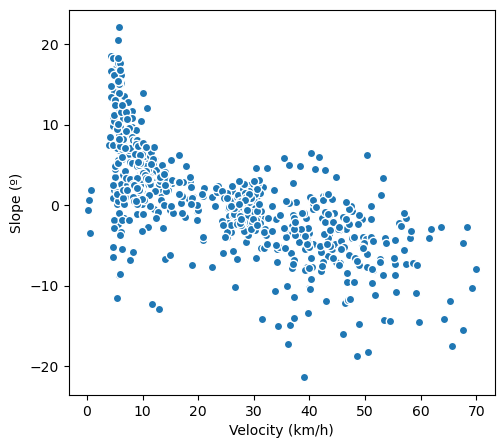

In [70]:
plt.figure(figsize=(5.5,5))

plt.scatter(df['Velocity'],df['Slope'],edgecolors='white')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Slope (º)')

Text(0, 0.5, 'Heartrate (bpm)')

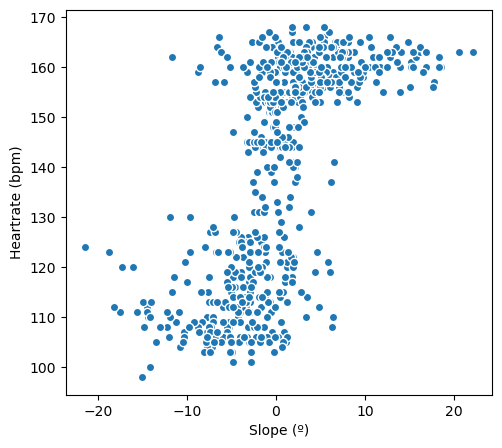

In [73]:
plt.figure(figsize=(5.5,5))

plt.scatter(df['Slope'],df['Heartrate'],edgecolors='white')
plt.xlabel('Slope (º)')
plt.ylabel('Heartrate (bpm)')

Text(0, 0.5, 'Velocity')

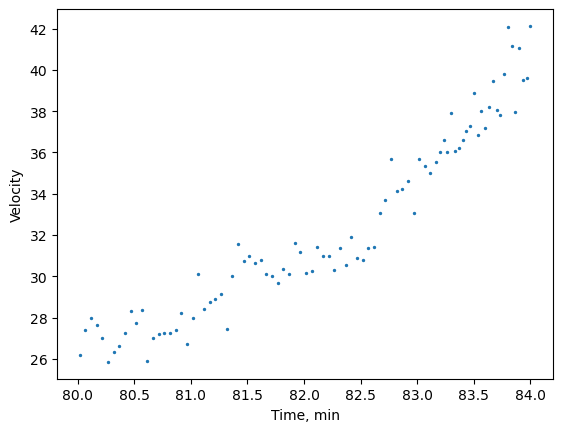

In [ ]:
#Plotting velocity
start_time = 80
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.scatter(filtered_df['Cumulative_Time'],filtered_df['Velocity'],s=2)

plt.xlabel('Time, min')
plt.ylabel('Velocity')

### Plotting heartrate vs velocity to find aerobic and anaerobic thresholds (Conconi test)
The test is performed by increasing the (cycling or running) velocity stepwise or gradually until reaching the maximum possible velocity and heartrate. The terrain should be flat and there should be no significant wind or other conditions that may perturb the velocity. The corresponding heartrate/velocity curve is a (pseudo)sigmoid curve and aerobic and anaerobic thresholds occur at its two bending points. 

Text(0, 0.5, 'Heartrate')

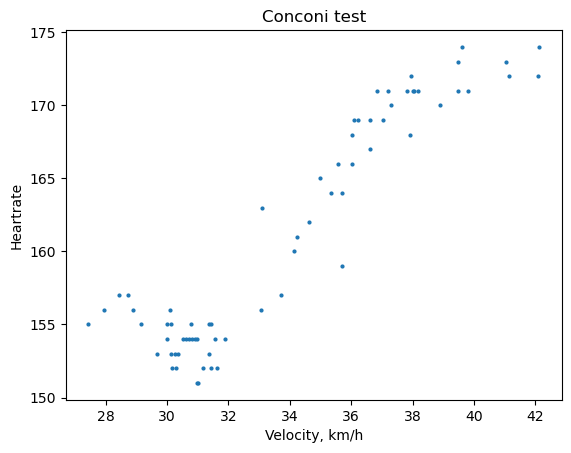

In [ ]:


# Specify the time range where the Conconi test was performed 
# (use the velocity-time plot above to find the exact start and end times for the test) 
'''
start_time = 39
end_time = 43.2
'''
start_time = 81
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.scatter(filtered_df['Velocity'],filtered_df['Heartrate'],s=4)

plt.title('Conconi test')
plt.xlabel('Velocity, km/h')
plt.ylabel('Heartrate')

From this plot aerobic and anaerobic thresholds can be estimated to be 155 and 172 bpm respectively.


### Trimming the track from a specified time on

In [25]:
# Trim track: Specify the minutes (check on the map) to find the row
target_value = 45.5

# Find the row number corresponding to the target value
row_number = df[(round(df['Cumulative_Time'],1)) == target_value ].index.item()

print(f"The row number corresponding to {target_value} min in 'Cumulative_Time' is {row_number}")
pd.DataFrame(df.iloc[row_number]).transpose()

The row number corresponding to 45.5 min in 'Cumulative_Time' is 663


,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
663,2023-11-19 12:21:33+00:00,41.266496,1.946292,6.21,0,45.5,15.682037,24.529809,0.684876,5.969,131.67,-0.028029,25.173743


In [26]:
def trim_gpx(gpx, output_file, num_points_to_keep):
    trimmed_gpx = gpxpy.gpx.GPX()

    for track in gpx.tracks:
        trimmed_track = gpxpy.gpx.GPXTrack()
        trimmed_gpx.tracks.append(trimmed_track)

        for segment in track.segments:
            trimmed_segment = gpxpy.gpx.GPXTrackSegment()
            trimmed_track.segments.append(trimmed_segment)

            # Keep only the first 'num_points_to_keep' points
            trimmed_segment.points = segment.points[:num_points_to_keep]

    # Save the trimmed GPX file
    with open(output_file, 'w') as trimmed_gpx_file:
        trimmed_gpx_file.write(gpx.to_xml())

output_filename = 'output_trimmed5.gpx'
num_points_to_keep = row_number

trim_gpx(gpx, output_filename, row_number)
print('File',output_filename,'saved')

File output_trimmed5.gpx saved
